# Model Tuning

Here we will evalute our baseline model to our previous models and attempt to build a better model using sentiment analysis and a voting classifier using our previous models as part of the voting classifier if we have time. 

In [71]:
# import our libraries

import pandas as pd
import numpy as np
import re
import textwrap

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.experimental import enable_hist_gradient_boosting, enable_halving_search_cv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
VotingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# import dataset

translated_df = pd.read_csv('../data/translated.csv')
translated_df.head()

,subreddit,merged_text
0,1,Fix to not being able to attack? Has anybody f...
1,1,Attack glitch during Regi raids 2 raids today ...
2,1,[Bug?] Can’t seem to earn or collect pokecoins...
3,1,"[Bug?] AR suddenly freezes Using an iPhone 11,..."
4,1,3 hour incense event personal results For any ...


In [73]:
# remove duplicate entries where text is the same
translated_df = translated_df.drop_duplicates('merged_text')

Now we get get sentiment scores for our text.

In [74]:
# thanks to Hov
# instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

translated_df['sentiment'] = translated_df['merged_text'].apply(get_compound_sentiment)

In [75]:
get_text_data = FunctionTransformer(lambda x: x['merged_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['sentiment']], validate = False)

In [76]:
# create baseline model
translated_df['subreddit'].value_counts()

1    10611
0     8642
Name: subreddit, dtype: int64

We will guess that all posts are from TheSilphRoad subreddit as it is our majority class.

In [77]:
# create train_test_split to evaluate our baseline model
X = translated_df[['merged_text', 'sentiment']]
y = translated_df['subreddit']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# create predictions for train and test set
y_train_preds = np.full_like(y_train, 1)
y_test_preds = np.full_like(y_test, 1)

print(f'Baseline accuracy on training data: {round(accuracy_score(y_train, y_train_preds), 2)}')
print(f'Baseline accuracy on testing data: {round(accuracy_score(y_test, y_test_preds), 2)}')

Baseline accuracy on training data: 0.55
Baseline accuracy on testing data: 0.55


Here we see that we have an baseline accuracy of 55% on both our training and testing data which is expected as about 55% of the posts we have are from TheSilphRoad subreddit and we used stratify for our train/test split. 

In [79]:
# create a custom stop words list to remove all similar words we found in the previous notebook

# start with the base english stopwords
new_stopwords = stopwords.words('english')

# add stopwords that will easily identify a silph post
# also added stopwords that are common across both subreddits and stop words as a result and lemmatizing and stemming
custom_words = ['silph', 'road', 'silphroad', 'thesilphroad', 'pokemon', 'go', 'get', 'one', 'like', 'would', 'know', 'time', 'game', 'shiny', 
               'https', 'raid', 'anyone', 'got', 'new', 'event', 'day', 'level', 'even', 'com', 'raids', 'still', 'people', 'also', 'since',
               'use', 'catch', 'amp', 'see', 'want', 'could', 'first', 'research', 'shadow', 'think', 'else', 'way', 'niantic', 'make', 
               'back', 'really', 'need', 'eggs', 'community', 'something', 'much', 'good', 'able', "'d", "'ll", "'re", "'s", "'ve", 'abl', 
                'abov', 'ani', 'anyon', 'becaus', 'befor', 'commun', 'doe', 'dure', 'egg', 'els', 'ha', 'hi', 'http', 'might', 'must', 
                "n't", 'onc', 'onli', 'ourselv', 'peopl', 'realli', 'sha', 'shini', 'sinc', 'someth', 'themselv', 'thi', 'veri', 'wa', 
                'whi', 'wo', 'yourselv', 'becau', 'el']

new_stopwords.extend(custom_words)

In [80]:
# custom preprocessing of text 
# thanks to the following article for the code: https://kavita-ganesan.com/how-to-use-countvectorizer/#CountVectorizer-Plain-and-Simple

lemmatizer = WordNetLemmatizer()
def lemma_preprocessor(text):
    text = text.lower()
    text = re.sub("\\W", " ", text) # remove special characters
    text = re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ", text) # normalize certain words
    
    #stem words
    words = re.split("\\s+", text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

porter_stemmer = PorterStemmer()
def stem_preprocessor(text):
    text = text.lower()
    text = re.sub("\\W", " ", text) # remove special characters
    text = re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ", text) # normalize certain words
    
    #stem words
    words = re.split("\\s+", text)
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [115]:
# generate our pipelines
cvec_sentiment_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words = new_stopwords, strip_accents = 'unicode'))
            ]))
    ])),
    ('densify', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('vote', VotingClassifier([
        ('logr', LogisticRegression(solver = 'liblinear', max_iter = 10000)),
        ('rforest', RandomForestClassifier()),
        ('bag', BaggingClassifier()),
        ('knn', KNeighborsClassifier()),
        ('etree', ExtraTreesClassifier()),
        ('xgb', XGBClassifier(use_label_encoder = False, n_jobs = 1, eval_metric = "logloss")),
        ('svc', SVC()), 
        ('histboost', HistGradientBoostingClassifier())
    ]))
])

tfidf_sentiment_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('tfidf', TfidfVectorizer(stop_words = new_stopwords, strip_accents = 'unicode')),
            ]))
    ])),
    ('densify', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('vote', VotingClassifier([
        ('logr', LogisticRegression(solver = 'liblinear', max_iter = 10000)),
        ('rforest', RandomForestClassifier()),
        ('bag', BaggingClassifier()),
        ('knn', KNeighborsClassifier()),
        ('etree', ExtraTreesClassifier()),
        ('xgb', XGBClassifier(use_label_encoder = False, n_jobs = 1, eval_metric = "logloss")),
        ('svc', SVC()),
        ('histboost', HistGradientBoostingClassifier())
    ]))
])

In [116]:
# create gridsearch parameters

cvec_sentiment_params = {
    'features__text_features__cvec__preprocessor': [lemma_preprocessor, stem_preprocessor],
    'features__text_features__cvec__ngram_range': [(1,1), (1,2), (1,3), (2,3),(3,3)],
    'features__text_features__cvec__max_df': np.linspace(0.8, 1.0, 10),
    'features__text_features__cvec__min_df': range(1,4),
    'features__text_features__cvec__max_features': range(10000, 100000, 100),
    'vote__logr__penalty': ['l1', 'l2'],
    'vote__logr__C': np.linspace(0.0001, 1, 50),
    'vote__rforest__n_estimators': range(50, 1000, 25),
    'vote__rforest__max_depth': range(10, 101, 4),
    'vote__rforest__max_features': ['sqrt', 'log2'],
    'vote__xgb__n_estimators': range(10, 1000, 100), 
    'vote__xgb__learning_rate': [0.01, 0.1, 0.3, 0.7],
    'vote__xgb__max_depth': [2, 5, 10], 
    'vote__xgb__min_child_weight': range(2, 100, 4), 
    'vote__histboost__learning_rate': np.linspace(0.01, 1, 50),
    'vote__histboost__max_iter': range(100, 10000, 200),
    'vote__histboost__max_depth': range(10, 101, 4),
}

tfidf_sentiment_params = {
    'features__text_features__tfidf__preprocessor': [lemma_preprocessor, stem_preprocessor],
    'features__text_features__tfidf__ngram_range': [(1,1), (1,2), (1,3), (2,3),(2,2),(3,3)],
    'features__text_features__tfidf__max_df': np.linspace(0.8, 1.0, 10),
    'features__text_features__tfidf__min_df': range(1,4),
    'features__text_features__tfidf__max_features': range(2000, 100000, 100),
    'vote__logr__penalty': ['l1', 'l2'],
    'vote__logr__C': np.linspace(0.0001, 1, 1000),
    'vote__rforest__n_estimators': range(50, 1000, 50),
    'vote__rforest__max_depth': range(10, 101, 2),
    'vote__rforest__max_features': ['sqrt', 'log2'],
    'vote__xgb__n_estimators': range(10, 1000, 50), 
    'vote__xgb__learning_rate': [0.01, 0.1, 0.3, 0.7],
    'vote__xgb__max_depth': [2, 5, 10], 
    'vote__xgb__min_child_weight': range(2, 100, 2), 
    'vote__histboost__learning_rate': np.linspace(0.01, 1, 100),
    'vote__histboost__max_iter': range(100, 10000, 100),
    'vote__histboost__max_depth': range(10, 101, 2),
}

In [117]:
cvec_sentiment_gs = HalvingRandomSearchCV(estimator = cvec_sentiment_pipe,
                                param_distributions = cvec_sentiment_params,
                                n_candidates = 10000,
                                verbose = 2, 
                                cv = 5, 
                                n_jobs = 50)

tfidf_sentiment_gs = HalvingRandomSearchCV(estimator = tfidf_sentiment_pipe,
                                param_distributions = tfidf_sentiment_params,
                                n_candidates = 10000,
                                verbose = 2, 
                                cv = 5, 
                                n_jobs = 50)

In [ ]:
# put all gridsearches into a list
gridsearches = [cvec_sentiment_gs, tfidf_sentiment_gs]

# create dictionary of gridsearches
gridsearch_dict = {0: 'Count Vectorizer Sentiment Voting', 1: 'TFIDF Sentiment Voting'}

# thanks to the following article for the code below: https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html

for i, gs in enumerate(gridsearches):
    print('\nEstimator: %s' % gridsearch_dict[i])
    gs.fit(X_train, y_train)
    print('Best Parameters: %s' % gs.best_params_)
    print('Training accuracy: %.3f' % gs.best_score_)
    y_pred = gs.predict(X_test)
    print('Test accurracy: %.3f' % accuracy_score(y_test, y_pred))


Estimator: Count Vectorizer Sentiment Voting
n_iterations: 7
n_required_iterations: 9
n_possible_iterations: 7
min_resources_: 20
max_resources_: 15402
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10000
n_resources: 20
Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


In [59]:
# create a dataframe with train and test scores of our models
model_score = pd.DataFrame({'model': ['Baseline', 'Count Vectorizer Logistic Regression', 'TFIDF Logistic Regression',
                                     'Count Vectorizer Naive Bayes', 'TFIDF Naive Bayes', 
                                     'Count Vectorizer K-Nearest Neighbors', 'TFIDF K-Nearest Neighbors', 
                                     'Count Vectorizer Random Forest', 'TFIDF Random Forest', 
                                     'Count Vectorizer XGBoost', 'TDIDF XGBoost', 
                                     'Count Vectorizer Support Vector Machine', 'TFIDF Support Vector Machine'] * 2,
                           'train/test': ['train' if i <= 12 else 'test' for i in range(26)],
                           'score': [0.55, 0.711, 0.667, 0.690, 0.707, 0.603, 0.681, 0.706, 0.711, 0.708, 0.698, 0.573, 0.715,
                                    0.55, 0.721, 0.678, 0.696, 0.720, 0.596, 0.683, 0.722, 0.723, 0.712, 0.703, 0.586, 0.723]})

,model,train/test,score
0,Baseline,train,0.550
1,Count Vectorizer Logistic Regression,train,0.711
2,TFIDF Logistic Regression,train,0.667
3,Count Vectorizer Naive Bayes,train,0.690
4,TFIDF Naive Bayes,train,0.707
5,Count Vectorizer K-Nearest Neighbors,train,0.603
6,TFIDF K-Nearest Neighbors,train,0.681
7,Count Vectorizer Random Forest,train,0.706
8,TFIDF Random Forest,train,0.711
9,Count Vectorizer XGBoost,train,0.708


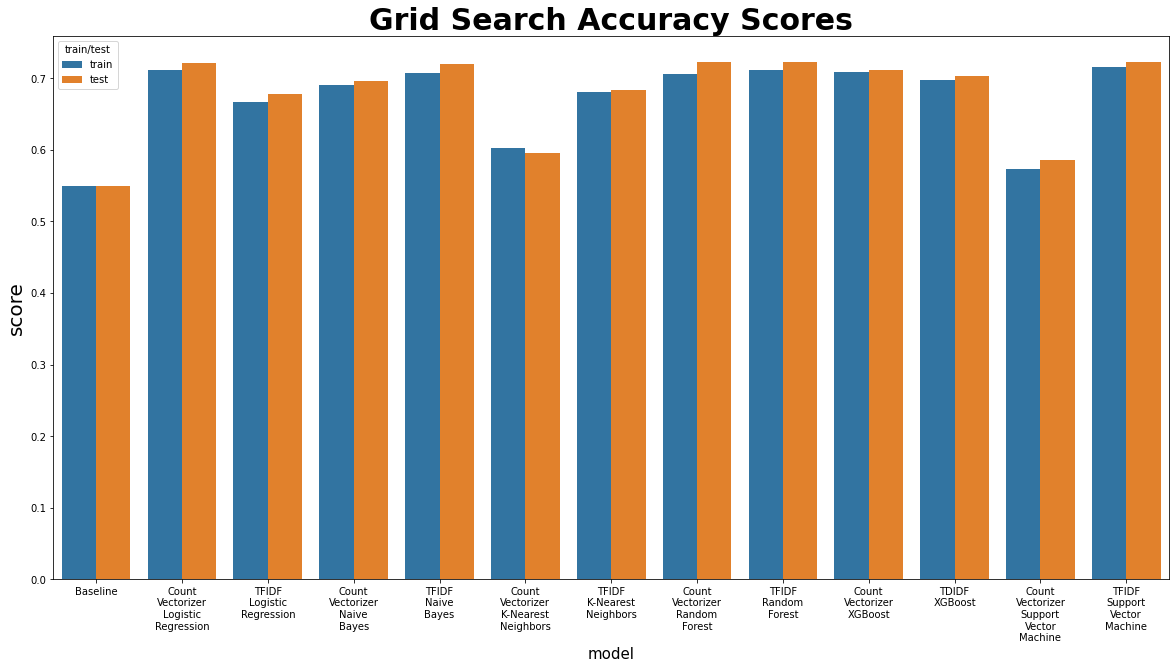

In [57]:
# create bar chart from our dataframe
max_width = 10
plt.figure(figsize = (20, 10))
plt.title('Grid Search Accuracy Scores', fontsize = 30, fontweight = 'bold')
ax = sns.barplot(y = model_score['score'], x = model_score['model'], hue = model_score['train/test'])
ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
ax.set_ylabel('score', fontsize = 20)
ax.set_xlabel('model', fontsize = 15);

As we can see, many of our models perform very similarly. I was most surprised that the random forest models were not overfit as they are known to be high variance models, but I guess that is what happens when you grid search enough hyperparameters to remove the variance. Another surprise was that one of our simpler models performed better than XGBoost, which is unexpected as XGBoost is a famous model for winning many classification competitions in the past. 